In [52]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [53]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
import scipy
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

### Let's read pre-generated coolpup pileups here - for all needed samples (NT/IAA) ...

In [59]:
# !scp shadow:/data/venevs/ALV-repo/PUP_DICT_5kb_SHIFT_EXP_PromEnhanc_detailed_stricter.pickle ./
import pickle
fp = open("PUP_DICT_5kb_SHIFT_EXP_PromEnhanc_detailed_stricter.pickle", "rb")
cpup_ep_dict = pickle.load(fp)
# Save object to file
fp.close()
#
cpup_ep_samples = list(cpup_ep_dict.keys())

In [60]:
list(cpup_ep_dict)

['CkoCT442_NT_pool.hg19', 'CkoCT442_IAA_pool.hg19']

In [61]:
# cpup_ep_dict["CkoCT442_NT_pool.hg19"][('enhancer', '.', 'tss', '+', '+')].loc["all","data"]
for k in cpup_ep_dict["CkoCT442_NT_pool.hg19"]:
    print(k)

('enhancer', '.', 'tss', '+', '+')
('enhancer', '.', 'tss', '+', '-')
('enhancer', '.', 'tss', '+', 'empty')
('enhancer', '.', 'tss', '-', '+')
('enhancer', '.', 'tss', '-', '-')
('enhancer', '.', 'tss', '-', 'empty')
('tss', '+', 'enhancer', '.', '+')
('tss', '+', 'enhancer', '.', '-')
('tss', '+', 'enhancer', '.', 'empty')
('tss', '-', 'enhancer', '.', '+')
('tss', '-', 'enhancer', '.', '-')
('tss', '-', 'enhancer', '.', 'empty')


In [62]:
def reverse_strand(strand):
    """
    reverse strand: +->-, -->+, .->.
    """
    if strand == "+":
        return "-"
    elif strand == "-":
        return "+"
    else:
        return strand

def flip_int(int_description):
    """
    flip promoter-enhancer pairs into Enhancer to Promoter
    """
    type1, strand1, type2, strand2, ctcf_status, *_bs = int_description
    if ctcf_status in ['+', '-']:
        return type2, reverse_strand(strand2), type1, reverse_strand(strand1), reverse_strand(ctcf_status), *_bs
    else:
        return type2, reverse_strand(strand2), type1, reverse_strand(strand1), ctcf_status, *_bs

def flip_PE(pe_tuple):
    """
    flip promoter-enhancer pairs into Enhancer--Promoter ones
    """
    t1, *_ = pe_tuple
    if t1 != "enhancer":
        return flip_int(pe_tuple)
    else:
        return pe_tuple

In [63]:
def combine_combinable_hms(sample_name, flip45=True ):
    """
    extract cpup pileup from that huge dictionary for a given sample (exp,size)
    and also flip45 if requested ...
    """
    #
    def rotate_hm(hm):
        # fill NaNs with 1.0 (obs==exp), otherwise flipping 45 breaks ...
        hm = np.nan_to_num(hm, nan=1.)
        _hm = scipy.ndimage.rotate(hm,45,cval=np.nan,reshape=True)
        l,w = _hm.shape
        half_l = l//2
        # removing upper pic spitz vershina "verh == up"
        pic_hide = int(0.33*half_l)
        return _hm[pic_hide:half_l,:]
    #
    combined_dict = {}
    mean_dict = {}
    _cpup_sample_dict = cpup_ep_dict[sample_name]
    for k, mat in _cpup_sample_dict.items():
        # extract mat:
        mat = mat.loc["all","data"]
        # flip PE to EP when needed
        if k[0] != "enhancer":
            # flip the key and corresponding HeatMap if it was PE
            k = flip_PE(k)
            mat = mat[::-1,::-1]
        # populate combined_dict now
        if k not in combined_dict:
            combined_dict[k] = [ mat ]
        else:
            # combine what can be combined - i.e. HMs with identical 
            combined_dict[k].append(mat)
            mean_dict[k] = np.nanmean(combined_dict[k],axis=0)
            if flip45:
                mean_dict[k] = rotate_hm(mean_dict[k])
    # returning all combined heatmaps as a dictionary
    return mean_dict

#### do the actual plotting ...

In [64]:
fig_samples = ['CkoCT442_NT_pool.hg19', 'CkoCT442_IAA_pool.hg19']

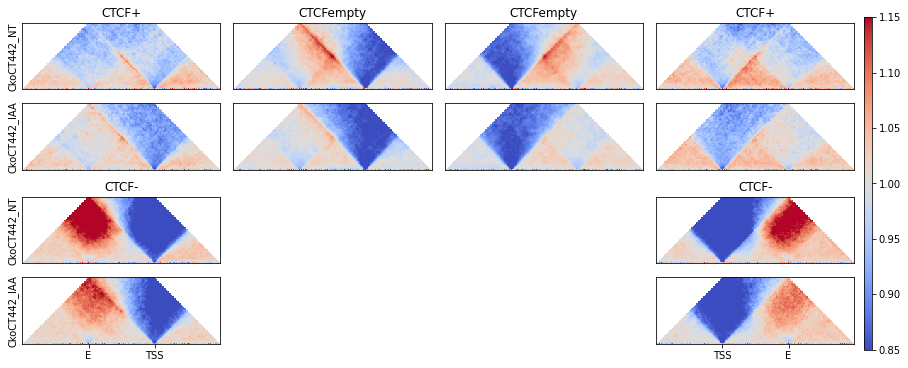

In [67]:
fig = plt.figure(figsize = (12.5,5), constrained_layout=True)
gs = fig.add_gridspec(2*len(fig_samples),4+1,width_ratios=[1,1,1,1,0.04])

# let's just do the coolpupping along the way ...
for row_id, sample_name in enumerate(cpup_ep_dict):
    avg_hm_dict = combine_combinable_hms(sample_name, flip45=True )
    for col_id, (tss_strand,ctcf_status) in enumerate([("+", "+"),
                                            ("+", "empty"),
                                            ("-", "empty"),
                                            ("-", "+")]):
        # coolpupping along the way ...
        ax = fig.add_subplot(gs[row_id, col_id])
        hhh = avg_hm_dict[('enhancer', '.', 'tss', tss_strand, ctcf_status)]
        if tss_strand == "-":
            hhh = hhh[:,::-1]
        cl = plt.imshow(hhh,
                        interpolation="none",
                        cmap="coolwarm",
                        norm = colors.TwoSlopeNorm(vmin=0.85,vcenter=1, vmax=1.15)
                       )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if row_id == 0:
            ax.set_title(f"CTCF{ctcf_status}")
        if col_id == 0:
            ax.set_ylabel(sample_name.rstrip(".hg19").rstrip("_pool"))
                
for row_id, sample_name in enumerate(cpup_ep_dict):
    row_id += len(cpup_ep_dict)
    avg_hm_dict = combine_combinable_hms(sample_name, flip45=True )
    for col_id, (tss_strand,ctcf_status) in enumerate([("+", "-"),
                                            (None,None),
                                            (None,None),
                                            ("-", "-")]):
        if (tss_strand, ctcf_status) == (None, None):
            continue
        # coolpupping along the way ...
        ax = fig.add_subplot(gs[row_id, col_id])
        hhh = avg_hm_dict[('enhancer', '.', 'tss', tss_strand, ctcf_status)]
        if tss_strand == "-":
            hhh = hhh[:,::-1]
        cl = plt.imshow(hhh,
                        interpolation="none",
                        cmap="coolwarm",
                        norm = colors.TwoSlopeNorm(vmin=0.85,vcenter=1, vmax=1.15)
                       )
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        if row_id == len(cpup_ep_dict):
            ax.set_title(f"CTCF{ctcf_status}")
        if col_id == 0:
            ax.set_ylabel(sample_name.rstrip(".hg19").rstrip("_pool"))
        if row_id == 2*len(fig_samples)-1:
            _,w = hhh.shape
            if ctcf_status == "ctcf":
                ax.set_xticks([w/3,w/2,2*w/3])
                ax.set_xticklabels(["E","CTCF","TSS"] if tss_strand=="+" else ["TSS","CTCF","E"])
            else:
                ax.set_xticks([w/3,2*w/3])
                ax.set_xticklabels(["E","TSS"] if tss_strand=="+" else ["TSS","E"])


# right side color bar
ax = fig.add_subplot(gs[:,-1])
bar = plt.colorbar(cl, cax=ax, orientation="vertical")

plt.savefig("Fig_RescaledEP_wCTCF_stricter.pdf")

In [51]:
# ! scp Fig_RescaledEP_wCTCF_stricter.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# ! scp SuppFigure7_*_clustered.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp Fig_RescaledEP_wCTCF.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/


Fig_RescaledEP_wCTCF.pdf                      100%  730KB   1.1MB/s   00:00    


In [ ]:
# fig = plt.figure(figsize = (12.5,3), constrained_layout=True)
# gs = fig.add_gridspec(len(fig_samples),4+1,width_ratios=[1,1,1,1,0.04])

# # let's just do the coolpupping along the way ...
# for row_id, sample_name in enumerate(cpup_ep_dict):
#     avg_hm_dict = combine_combinable_hms(sample_name, flip45=True )
#     for col_id, (tss_strand,ctcf_status) in enumerate([("+", "+"),
#                                             ("+", "empty"),
#                                             ("-", "empty"),
#                                             ("-", "+")]):
#         # coolpupping along the way ...
#         ax = fig.add_subplot(gs[row_id, col_id])
#         hhh = avg_hm_dict[('enhancer', '.', 'tss', tss_strand, ctcf_status)]
#         if tss_strand == "-":
#             hhh = hhh[:,::-1]
#         cl = plt.imshow(hhh,
#                         interpolation="none",
#                         cmap="coolwarm",
#                         norm = colors.TwoSlopeNorm(vmin=0.85,vcenter=1, vmax=1.15)
#                        )
#         ax.set_xticks([])
#         ax.set_xticklabels([])
#         ax.set_yticks([])
#         ax.set_yticklabels([])
#         if row_id == 0:
#             ax.set_title( (tss_strand,ctcf_status) )
#         if col_id == 0:
#             ax.set_ylabel(sample_name.rstrip(".hg19"))
#         if row_id == len(fig_samples)-1:
#             _,w = hhh.shape
#             if ctcf_status == "ctcf":
#                 ax.set_xticks([w/3,w/2,2*w/3])
#                 ax.set_xticklabels(["E","CTCF","TSS"] if tss_strand=="+" else ["TSS","CTCF","E"])
#             else:
#                 ax.set_xticks([w/3,2*w/3])
#                 ax.set_xticklabels(["E","TSS"] if tss_strand=="+" else ["TSS","E"])

        
# # right side color bar
# ax = fig.add_subplot(gs[:,-1])
# bar = plt.colorbar(cl, cax=ax, orientation="vertical")